In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

In [2]:
train = datasets.MNIST("", train=True, download=True,
                       transform = transforms.Compose(
                           [transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True,
                       transform = transforms.Compose(
                           [transforms.ToTensor()]))

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [4]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [5]:
x, y = data[0][0], data[1][0]

print(y)

tensor(8)


In [6]:
import matplotlib.pyplot as plt

print(data[0][0].shape)
plt.imshow(data[0][0].view(28, 28))

torch.Size([1, 28, 28])


In [7]:
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0,
                7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total +=1
print(counter_dict)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [8]:
for i in counter_dict:
    print(f"{i}: {counter_dict[i]/total*100}")

0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64) # fc=fully connected
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) #Rectified Linear
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1)


net = Net()
net = net
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


tensor([[-2.3637, -2.4059, -2.2804, -2.2097, -2.1124, -2.2543, -2.3079, -2.4481,
         -2.3605, -2.3271]], grad_fn=<LogSoftmaxBackward>)


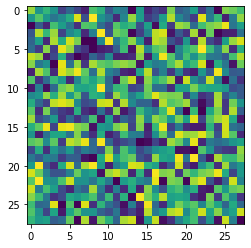

In [11]:
X = torch.rand((28, 28))
X = X.view(-1, 28*28) # -1 specifies an unknown size
output = net(X)
print(output)
plt.imshow(X.view(28, 28))

In [19]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001) # lr=learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 3
for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data # data = featuresets and labels
        # print(X[0])
        # print(y[0])
        # plt.imshow(X[0][0])
        # break
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print(loss)


tensor(0.0162, grad_fn=<NllLossBackward>)
tensor(0.0033, grad_fn=<NllLossBackward>)
tensor(0.0046, grad_fn=<NllLossBackward>)


In [22]:
correct = 0
total = 0

torch.cuda.is_available()

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.968


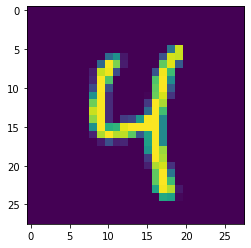

In [31]:
import matplotlib.pyplot as plt
plt.imshow(X[3].view(28,28))
plt.show()

In [30]:
print(torch.argmax(net(X[3].view(-1, 28*28))[0]))

tensor(4)
